# 1. Install Dependencies and Setup

In [80]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
   

In [81]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8

In [82]:
import tensorflow as tf
import os

In [83]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [84]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [85]:
import cv2
import imghdr

In [86]:
data_dir = 'data' 

In [87]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [88]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [89]:
import numpy as np
from matplotlib import pyplot as plt

In [90]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [91]:
data_iterator = data.as_numpy_iterator()

In [92]:
batch = data_iterator.next()

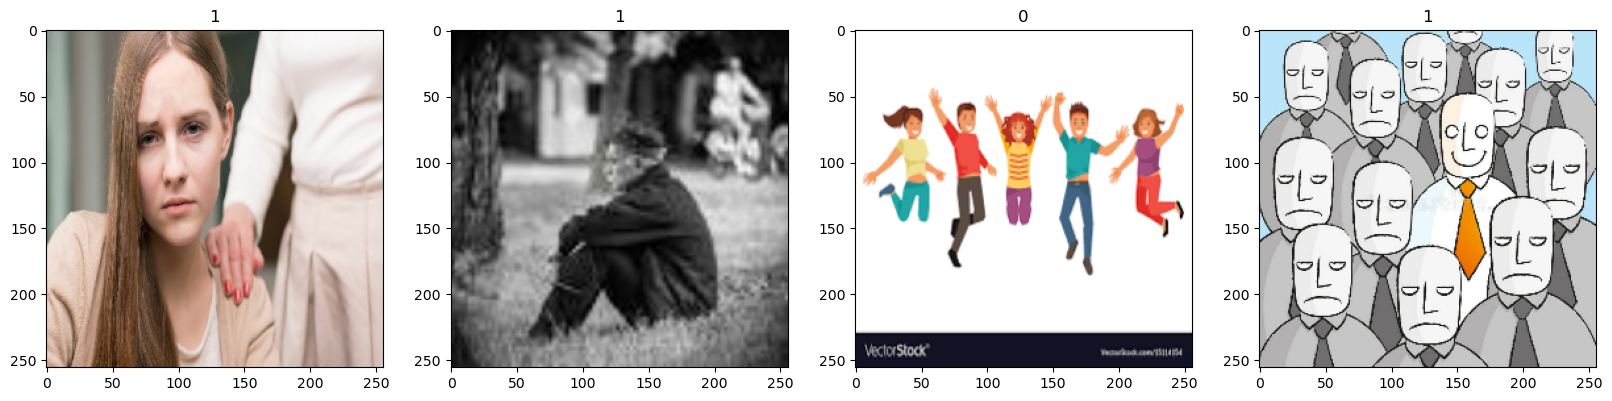

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [94]:
data = data.map(lambda x,y: (x/255, y))

In [95]:
data.as_numpy_iterator().next()

(array([[[[0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          ...,
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216]],
 
         [[0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          ...,
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216]],
 
         [[0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          ...,
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216],
          [0.7294118 , 0.89411765, 0.98039216]],
 
         ...,
 
         [[0.7005821 , 0.69273895, 0.6966605 ],
          [0.70173

# 5. Split Data

In [96]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [97]:
train_size

7

In [98]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [99]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [101]:
model = Sequential()

In [102]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [103]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [105]:
logdir='logs'

In [106]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [107]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 12s 1s/step - loss: 0.9875 - accuracy: 0.5000 - val_loss: 0.6769 - val_accuracy: 0.6562
Epoch 2/20
7/7 [==============================] - 8s 766ms/step - loss: 0.6594 - accuracy: 0.5580 - val_loss: 0.5655 - val_accuracy: 0.7188
Epoch 3/20
7/7 [==============================] - 7s 629ms/step - loss: 0.5320 - accuracy: 0.7188 - val_loss: 0.9839 - val_accuracy: 0.5625
Epoch 4/20
7/7 [==============================] - 5s 492ms/step - loss: 0.6266 - accuracy: 0.6339 - val_loss: 0.5427 - val_accuracy: 0.8125
Epoch 5/20
7/7 [==============================] - 5s 485ms/step - loss: 0.5273 - accuracy: 0.7857 - val_loss: 0.4894 - val_accuracy: 0.6719
Epoch 6/20
7/7 [==============================] - 5s 491ms/step - loss: 0.4494 - accuracy: 0.8036 - val_loss: 0.4094 - val_accuracy: 0.7812
Epoch 7/20
7/7 [==============================] - 7s 755ms/step - loss: 0.3716 - accuracy: 0.8482 - val_loss: 0.3434 - val_accuracy: 0.8906
Epoch 8/20
7/7 [======

# 8. Plot Performance

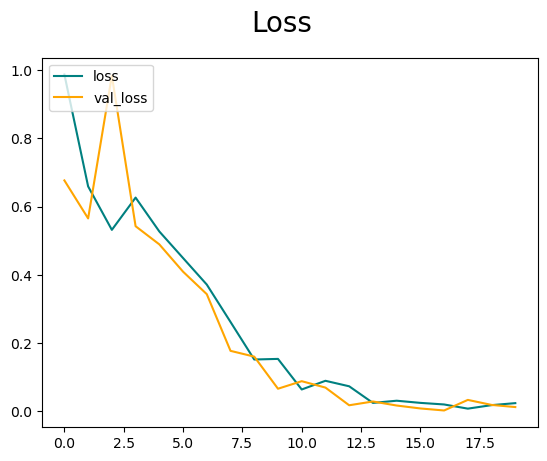

In [108]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

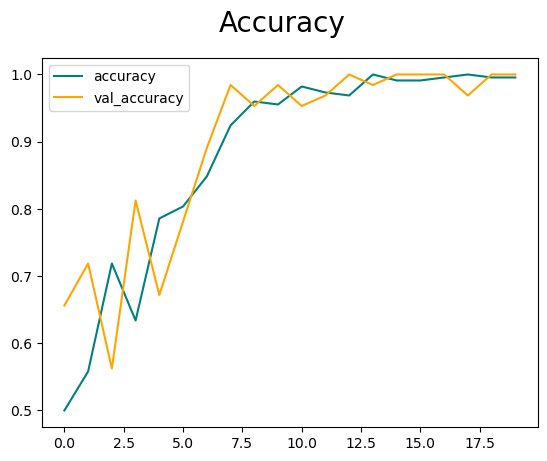

In [109]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [110]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [111]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [112]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 563ms/step


In [113]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.8888889, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


# 10. Test

In [114]:
import cv2

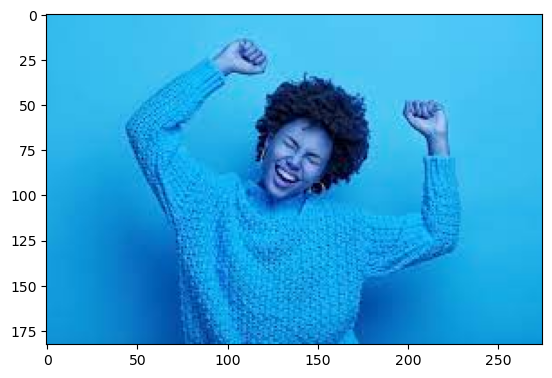

In [115]:
img = cv2.imread('vui.jpg')
plt.imshow(img)
plt.show()

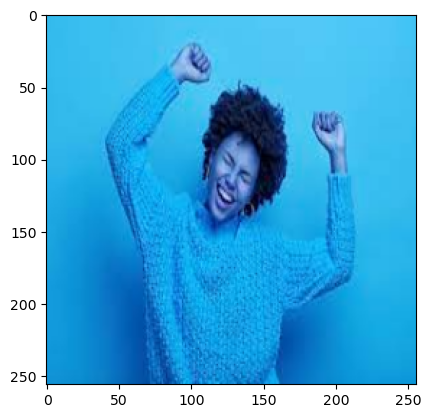

In [116]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [117]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 75ms/step


In [118]:
yhat

array([[0.01734526]], dtype=float32)

In [119]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [120]:
from tensorflow.keras.models import load_model

In [121]:
model.save(os.path.join('models','imageclassifier.h5'))

c:\Users\PC\anaconda3\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [122]:
new_model = load_model('C:\\Users\\PC\\Downloads\\ImageClassification-main\\ImageClassification-main\\models\\imageclassifier.h5')

In [123]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 230ms/step


array([[0.01734526]], dtype=float32)

In [124]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib pyspark


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\PC\anaconda3\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
   


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [125]:
import tensorflow as tf
import os
import numpy as np
import cv2
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType


In [126]:
def load_tf_model(model_dir):
    def predict(inputs):
        model = tf.keras.models.load_model(model_dir)
        return model.predict(inputs)

    return predict

# Define the model directory
model_dir = "models/imageclassifier.h5"


In [127]:
image_classifier_udf = predict_batch_udf(load_tf_model(model_dir),
                                         input_tensor_shapes=[[256, 256, 3]],
                                         return_type=ArrayType(FloatType()),
                                         batch_size=16)
from pyspark.sql.functions import col, lit
from pyspark.sql.types import BinaryType
from pyspark.sql.functions import udf

def resize_image(image_data, dimensions):
    # Convert image_data to numpy array
    image_array = np.frombuffer(image_data, dtype=np.uint8)
    # Reshape image to original dimensions
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Resize image
    resized_image = cv2.resize(image, dimensions)
    # Convert resized image back to binary format
    _, encoded_image = cv2.imencode('.jpg', resized_image)
    return bytearray(encoded_image)

# Register UDF for resizing images
resize_udf = udf(resize_image, BinaryType())


In [128]:
from pyspark.sql import SparkSession

# Khởi tạo một phiên Spark
spark = SparkSession.builder \
    .appName("Classifcation_image") \
    .getOrCreate()

# Đọc dữ liệu hình ảnh vào một DataFrame Spark
image_df = spark.read.format("image").load("data")


In [129]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import BinaryType

def resize_image(image_data, width, height):
    # Convert image_data to numpy array
    image_array = np.frombuffer(image_data, dtype=np.uint8)
    # Reshape image to original dimensions
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Resize image
    resized_image = cv2.resize(image, (width, height))
    # Convert resized image back to binary format
    _, encoded_image = cv2.imencode('.jpg', resized_image)
    return bytearray(encoded_image)

# Register UDF for resizing images
resize_udf = udf(resize_image, BinaryType())

# Read images into a Spark DataFrame
image_df = spark.read.format("image").load("data")

# Resize images to match the input size of the model
image_df = image_df.withColumn("resized_image", 
                               resize_udf(col("image.data"), lit(256), lit(256)))

# Select only the resized images
image_df = image_df.select("resized_image")

# Cache the DataFrame
image_df.cache()


DataFrame[resized_image: binary]

In [130]:
# Add predictions column to DataFrame
predictions_df = image_df.withColumn("predictions", image_classifier_udf(struct(*image_df.columns)))


In [131]:
predictions = predictions_df.select("predictions").collect()


In [138]:
# Load ảnh vào DataFrame Spark
image_path = "C:\\Users\\PC\\Downloads\\ImageClassification-main\\ImageClassification-main\\vui.jpg"
image = cv2.imread(image_path)
# Chuẩn bị ảnh cho việc dự đoán
resized_image = cv2.resize(image, (256, 256))  # Resize ảnh về kích thước đầu vào của mô hình
preprocessed_image = resized_image / 255.0  # Chuẩn hóa pixel về khoảng [0, 1]

In [139]:
# Dự đoán với mô hình TensorFlow
model = tf.keras.models.load_model("models/imageclassifier.h5")
prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))

1/1 [==============================] - 0s 137ms/step


In [140]:
# Xuất kết quả
if prediction > 0.5:
    print("Predicted class is Sad")
else:
    print("Predicted class is Happy")

Predicted class is Happy
